# Classifier

cnn architecture to classify numbers from 0 to 999

this classifier uses a dataset made of concatenated images on the horizontal axis (width)

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

In [25]:
import utils_datasets
import utils
import importlib
importlib.reload(utils)

<module 'utils' from 'c:\\Local Disk D_827202219\\bacco\\Università\\Parma-Bologna\\Year 1\\s.2\\Deep learning\\DeepLearning-Project-Assignment\\utils.py'>

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Model

In [5]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        # first convolutional block
        # initial size = 1x32x32
        self.conv_block1 = nn.Sequential(nn.Conv2d(in_channels= 1, out_channels=32, kernel_size=5, stride=1, padding=2), #32x32x32 [(W−K+2P)/S]+1
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2, 2)) #32x16x16
        # second convolutional block
        self.conv_block2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2), #64x16x16
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2, 2)) #64x8x8
        # third convolutional block
        self.conv_block3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=256, kernel_size=5, stride=1, padding=2), #256x8x8
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2, 2)) #256x4x4
        # fully connected blocks
        self.fc1 = nn.Flatten(1)
        self.fc2 = nn.Sequential(
            nn.Linear(256 * 4 * 4, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5))
        self.fc3 = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5))
        self.fc4 = nn.Linear(1024, 1000)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x


net = LeNet5().to(device)
print(net)

LeNet5(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Flatten(start_dim=1, end_dim=-1)
  (fc2): Sequential(
    (0): Linear(in_features=4096, out

### Training

In [6]:
# define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [7]:
train_batch_size = 64
test_batch_size = 1000

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(utils_datasets.mnist_mean, utils_datasets.mnist_std)
])

def denormalize(img, std, mean):
    img = img * std
    return img + mean

defining the dataset and dataloader from which the data will be extracted

In [8]:
train_dataset = utils_datasets.DynamicWMNIST(transform=transform_train, dataset_size=150000)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

training

In [ ]:
# TRAIN!
# put net into train mode
net.train()
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # put data on correct device
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0

print('Finished Training')

### Save/Load the model

In [ ]:
# Save the model
PATH = './res/LeNet5W_7.pth'
torch.save(net.state_dict(), PATH)

In [9]:
# Load the model
PATH = './res/LeNet5W_7.pth'
net.load_state_dict(torch.load(PATH, device))

<All keys matched successfully>

### Test

In [10]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(utils_datasets.mnist_mean, utils_datasets.mnist_std)
])

defining the dataset and dataloader from which the data will be extracted

In [ ]:
test_dataset = utils_datasets.testMNISTDataset('./data/testWMNIST/', transform_test)
test_dataloader = DataLoader(test_dataset,
                              test_batch_size,
                              shuffle=False)

testing

In [ ]:
# number of correct prediction
correct = 0.0 
# total number of prediction
total = 0-0
# number of correct predition every 10 mini-batches
running_accuracy = 0.0

# put net into evaluation mode
net.eval()

with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        # put data on correct device
        inputs, labels = inputs.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # picking the class with the highest value as prediction
        _, predicted = torch.max(outputs.data, 1)
        # updating the stats
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_accuracy += (predicted == labels).sum().item()

        if i % 10 == 9:    # print every 10 mini-batches
            print(f'[batch {i + 1:5d}] accuracy: {100 * running_accuracy // (10 * labels.size(0))} %')
            running_accuracy = 0.0

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

In [ ]:
# number of correct prediction
correct = 0.0 
# total number of prediction
total = 0.0
# number of correct predition every 10 mini-batches
running_accuracy = 0.0
# total erroneous prediction
err = 0
# erroneous prediction on one digit numbers
unit_err = 0
# erroneous prediction on two digit numbers
dec_err = 0
# erroneous prediction on three digit numbers
cent_err = 0
# put net into evaluation mode
net.eval()

with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        # put data on correct device
        inputs, labels = inputs.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # picking the class with the highest value as prediction
        _, predicted = torch.max(outputs.data, 1)
        # updating the stats
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_accuracy += (predicted == labels).sum().item()
        for p, l in zip(predicted, labels):
            if p != l:
                err += 1
                if l < 10:
                    unit_err +=1
                elif l < 100:
                    dec_err +=1
                else: 
                    cent_err +=1
                    
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'[batch {i + 1:5d}] accuracy: {100 * running_accuracy // (10 * labels.size(0))} %')
            print(f'[batch {i + 1:5d}] total error: {err}, unit_err: {unit_err}, dec_err: {dec_err}, cent_err: {cent_err}')
            running_accuracy = 0.0
            
print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')
print(f'err: {err}, unit_err: {unit_err}, dec_err: {dec_err}, cent_err: {cent_err}')

the predicted class is: 797


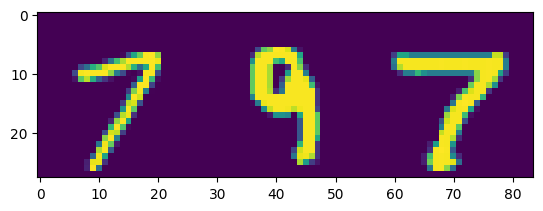

In [48]:
utils.predict_img('./data/TestWMNIST/797/1.png', net, transform_test)